In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/home/jackalhan/Development/github/more_meaningful_representations/venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
x_data = np.linspace(0.0, 10.0, 1000000)

In [3]:
noise = np.random.randn(len(x_data))

y = mx + b

b = 5

In [4]:
y_true = (0.5 * x_data) + 5 + noise

In [5]:
x_df = pd.DataFrame(data=x_data, columns=['X Data'])

In [6]:
y_df = pd.DataFrame(data=y_true, columns=['Y'])

In [7]:
x_df.head()

,X Data
0,0.00000
1,0.00001
2,0.00002
3,0.00003
4,0.00004


In [8]:
y_df.head()

,Y
0,3.656070
1,3.644143
2,5.374524
3,5.682985
4,6.274614


In [9]:
my_data = pd.concat([x_df, y_df], axis=1)
my_data.head()

,X Data,Y
0,0.00000,3.656070
1,0.00001,3.644143
2,0.00002,5.374524
3,0.00003,5.682985
4,0.00004,6.274614


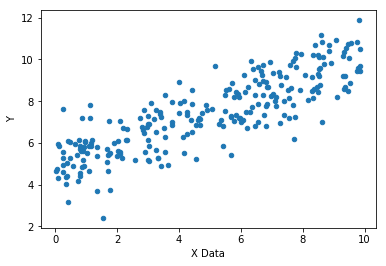

In [10]:
#random samples from pandas to plot
my_data.sample(n=250).plot(kind='scatter', x='X Data', y='Y')


In [11]:
batch_size = 8

In [12]:
rands = np.random.rand(2)

In [13]:
m = tf.Variable(float(rands[0]))
b = tf.Variable(float(rands[1]))

In [14]:
x_ph = tf.placeholder(tf.float32, [batch_size])

In [15]:
y_ph = tf.placeholder(tf.float32, [batch_size])

In [16]:
y_model = m * x_ph +b

In [17]:
# loss function
error = tf.reduce_sum(tf.square(y_ph-y_model))

In [18]:
# optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train_to_optimize = optimizer.minimize(error)

In [19]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    batches = 100000
    for i in range(batches):
        rand_ind = np.random.randint(len(x_data), size=batch_size)
        feed = {x_ph:x_data[rand_ind], y_ph:y_true[rand_ind]}
        sess.run(train_to_optimize, feed_dict=feed )
    model_m, model_b = sess.run([m,b])


In [20]:
model_m

0.4770387

In [21]:
model_b

5.08232

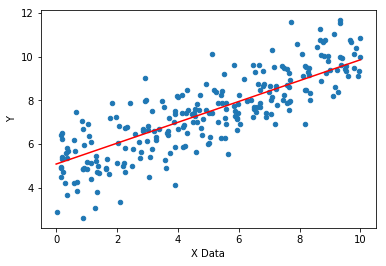

In [22]:
y_hat = x_data * model_m + model_b
my_data.sample(250).plot(kind='scatter', x='X Data', y='Y')
plt.plot(x_data, y_hat, 'r')

### TF ESTIMATOR API

In [27]:
# x_data has 1 dimension but we need to interpret it as a list of columns
# all feature columns have set up
feat_cols = [ tf.feature_column.numeric_column('x', shape = [1]) ] 

In [28]:
estimator = tf.estimator.LinearRegressor(feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f38948bccf8>, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_service': None, '_log_step_count_steps': 100, '_tf_random_seed': None, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_keep_checkpoint_max': 5, '_master': '', '_task_id': 0, '_is_chief': True, '_task_type': 'worker', '_model_dir': '/tmp/tmp5eqgd3dr', '_save_checkpoints_steps': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600}


In [29]:
from sklearn.model_selection import train_test_split

In [30]:
x_train, x_eval, y_train, y_eval = train_test_split(x_data, y_true, test_size = 0.3, random_state = 101)

In [32]:
x_eval.shape

(300000,)

In [33]:
# input function : acts like we are feedin the dictionary and batch size all at once
# pandas or numpy, where the type of data is coming from
input_func = tf.estimator.inputs.numpy_input_fn({'x': x_train}, 
                                                y_train,
                                                batch_size=8,
                                                num_epochs=None,
                                                shuffle=True)

In [34]:
train_input_func = tf.estimator.inputs.numpy_input_fn({'x': x_train}, 
                                                y_train,
                                                batch_size=8,
                                                num_epochs=1000,
                                                shuffle=False)

In [35]:
eval_input_func = tf.estimator.inputs.numpy_input_fn({'x': x_eval}, 
                                                y_eval,
                                                batch_size=8,
                                                num_epochs=1000,
                                                shuffle=False)

In [36]:
# train the estimator
estimator.train(input_func, steps=1000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp5eqgd3dr/model.ckpt.
INFO:tensorflow:step = 1, loss = 552.90076
INFO:tensorflow:global_step/sec: 178.718
INFO:tensorflow:step = 101, loss = 18.928814 (0.560 sec)
INFO:tensorflow:global_step/sec: 179.576
INFO:tensorflow:step = 201, loss = 17.769882 (0.557 sec)
INFO:tensorflow:global_step/sec: 157.734
INFO:tensorflow:step = 301, loss = 8.591568 (0.632 sec)
INFO:tensorflow:global_step/sec: 166.071
INFO:tensorflow:step = 401, loss = 14.928666 (0.603 sec)
INFO:tensorflow:global_step/sec: 189.853
INFO:tensorflow:step = 501, loss = 10.617271 (0.527 sec)
INFO:tensorflow:global_step/sec: 171.51
INFO:tensorflow:step = 601, loss = 9.31443 (0.583 sec)
INFO:tensorflow:global_step/sec: 169.503
INFO:tensorflow:step = 701, loss = 10.010174 (0.591 sec)
INFO:tensorflow:global_step/sec: 181.777
INFO:tensorflow:step = 801, loss = 8.248226 (0.550 sec)
INFO:tensorflow:global_step/sec: 169.13
INFO:tensorflow:ste

In [37]:
# Evaluation matrix for training data, in order to do evaluation correctly, we did not shuffle the 
# original train_inpt_func
train_matrix = estimator.evaluate(train_input_func, steps=1000)

INFO:tensorflow:Starting evaluation at 2018-03-27-23:10:37
INFO:tensorflow:Restoring parameters from /tmp/tmp5eqgd3dr/model.ckpt-1000
INFO:tensorflow:Evaluation [1/1000]
INFO:tensorflow:Evaluation [2/1000]
INFO:tensorflow:Evaluation [3/1000]
INFO:tensorflow:Evaluation [4/1000]
INFO:tensorflow:Evaluation [5/1000]
INFO:tensorflow:Evaluation [6/1000]
INFO:tensorflow:Evaluation [7/1000]
INFO:tensorflow:Evaluation [8/1000]
INFO:tensorflow:Evaluation [9/1000]
INFO:tensorflow:Evaluation [10/1000]
INFO:tensorflow:Evaluation [11/1000]
INFO:tensorflow:Evaluation [12/1000]
INFO:tensorflow:Evaluation [13/1000]
INFO:tensorflow:Evaluation [14/1000]
INFO:tensorflow:Evaluation [15/1000]
INFO:tensorflow:Evaluation [16/1000]
INFO:tensorflow:Evaluation [17/1000]
INFO:tensorflow:Evaluation [18/1000]
INFO:tensorflow:Evaluation [19/1000]
INFO:tensorflow:Evaluation [20/1000]
INFO:tensorflow:Evaluation [21/1000]
INFO:tensorflow:Evaluation [22/1000]
INFO:tensorflow:Evaluation [23/1000]
INFO:tensorflow:Evaluati

INFO:tensorflow:Evaluation [216/1000]
INFO:tensorflow:Evaluation [217/1000]
INFO:tensorflow:Evaluation [218/1000]
INFO:tensorflow:Evaluation [219/1000]
INFO:tensorflow:Evaluation [220/1000]
INFO:tensorflow:Evaluation [221/1000]
INFO:tensorflow:Evaluation [222/1000]
INFO:tensorflow:Evaluation [223/1000]
INFO:tensorflow:Evaluation [224/1000]
INFO:tensorflow:Evaluation [225/1000]
INFO:tensorflow:Evaluation [226/1000]
INFO:tensorflow:Evaluation [227/1000]
INFO:tensorflow:Evaluation [228/1000]
INFO:tensorflow:Evaluation [229/1000]
INFO:tensorflow:Evaluation [230/1000]
INFO:tensorflow:Evaluation [231/1000]
INFO:tensorflow:Evaluation [232/1000]
INFO:tensorflow:Evaluation [233/1000]
INFO:tensorflow:Evaluation [234/1000]
INFO:tensorflow:Evaluation [235/1000]
INFO:tensorflow:Evaluation [236/1000]
INFO:tensorflow:Evaluation [237/1000]
INFO:tensorflow:Evaluation [238/1000]
INFO:tensorflow:Evaluation [239/1000]
INFO:tensorflow:Evaluation [240/1000]
INFO:tensorflow:Evaluation [241/1000]
INFO:tensorf

INFO:tensorflow:Evaluation [432/1000]
INFO:tensorflow:Evaluation [433/1000]
INFO:tensorflow:Evaluation [434/1000]
INFO:tensorflow:Evaluation [435/1000]
INFO:tensorflow:Evaluation [436/1000]
INFO:tensorflow:Evaluation [437/1000]
INFO:tensorflow:Evaluation [438/1000]
INFO:tensorflow:Evaluation [439/1000]
INFO:tensorflow:Evaluation [440/1000]
INFO:tensorflow:Evaluation [441/1000]
INFO:tensorflow:Evaluation [442/1000]
INFO:tensorflow:Evaluation [443/1000]
INFO:tensorflow:Evaluation [444/1000]
INFO:tensorflow:Evaluation [445/1000]
INFO:tensorflow:Evaluation [446/1000]
INFO:tensorflow:Evaluation [447/1000]
INFO:tensorflow:Evaluation [448/1000]
INFO:tensorflow:Evaluation [449/1000]
INFO:tensorflow:Evaluation [450/1000]
INFO:tensorflow:Evaluation [451/1000]
INFO:tensorflow:Evaluation [452/1000]
INFO:tensorflow:Evaluation [453/1000]
INFO:tensorflow:Evaluation [454/1000]
INFO:tensorflow:Evaluation [455/1000]
INFO:tensorflow:Evaluation [456/1000]
INFO:tensorflow:Evaluation [457/1000]
INFO:tensorf

INFO:tensorflow:Evaluation [648/1000]
INFO:tensorflow:Evaluation [649/1000]
INFO:tensorflow:Evaluation [650/1000]
INFO:tensorflow:Evaluation [651/1000]
INFO:tensorflow:Evaluation [652/1000]
INFO:tensorflow:Evaluation [653/1000]
INFO:tensorflow:Evaluation [654/1000]
INFO:tensorflow:Evaluation [655/1000]
INFO:tensorflow:Evaluation [656/1000]
INFO:tensorflow:Evaluation [657/1000]
INFO:tensorflow:Evaluation [658/1000]
INFO:tensorflow:Evaluation [659/1000]
INFO:tensorflow:Evaluation [660/1000]
INFO:tensorflow:Evaluation [661/1000]
INFO:tensorflow:Evaluation [662/1000]
INFO:tensorflow:Evaluation [663/1000]
INFO:tensorflow:Evaluation [664/1000]
INFO:tensorflow:Evaluation [665/1000]
INFO:tensorflow:Evaluation [666/1000]
INFO:tensorflow:Evaluation [667/1000]
INFO:tensorflow:Evaluation [668/1000]
INFO:tensorflow:Evaluation [669/1000]
INFO:tensorflow:Evaluation [670/1000]
INFO:tensorflow:Evaluation [671/1000]
INFO:tensorflow:Evaluation [672/1000]
INFO:tensorflow:Evaluation [673/1000]
INFO:tensorf

INFO:tensorflow:Evaluation [864/1000]
INFO:tensorflow:Evaluation [865/1000]
INFO:tensorflow:Evaluation [866/1000]
INFO:tensorflow:Evaluation [867/1000]
INFO:tensorflow:Evaluation [868/1000]
INFO:tensorflow:Evaluation [869/1000]
INFO:tensorflow:Evaluation [870/1000]
INFO:tensorflow:Evaluation [871/1000]
INFO:tensorflow:Evaluation [872/1000]
INFO:tensorflow:Evaluation [873/1000]
INFO:tensorflow:Evaluation [874/1000]
INFO:tensorflow:Evaluation [875/1000]
INFO:tensorflow:Evaluation [876/1000]
INFO:tensorflow:Evaluation [877/1000]
INFO:tensorflow:Evaluation [878/1000]
INFO:tensorflow:Evaluation [879/1000]
INFO:tensorflow:Evaluation [880/1000]
INFO:tensorflow:Evaluation [881/1000]
INFO:tensorflow:Evaluation [882/1000]
INFO:tensorflow:Evaluation [883/1000]
INFO:tensorflow:Evaluation [884/1000]
INFO:tensorflow:Evaluation [885/1000]
INFO:tensorflow:Evaluation [886/1000]
INFO:tensorflow:Evaluation [887/1000]
INFO:tensorflow:Evaluation [888/1000]
INFO:tensorflow:Evaluation [889/1000]
INFO:tensorf

In [38]:
#matrix for test
eval_matrix = estimator.evaluate(eval_input_func, steps=1000)

INFO:tensorflow:Starting evaluation at 2018-03-27-23:14:06
INFO:tensorflow:Restoring parameters from /tmp/tmp5eqgd3dr/model.ckpt-1000
INFO:tensorflow:Evaluation [1/1000]
INFO:tensorflow:Evaluation [2/1000]
INFO:tensorflow:Evaluation [3/1000]
INFO:tensorflow:Evaluation [4/1000]
INFO:tensorflow:Evaluation [5/1000]
INFO:tensorflow:Evaluation [6/1000]
INFO:tensorflow:Evaluation [7/1000]
INFO:tensorflow:Evaluation [8/1000]
INFO:tensorflow:Evaluation [9/1000]
INFO:tensorflow:Evaluation [10/1000]
INFO:tensorflow:Evaluation [11/1000]
INFO:tensorflow:Evaluation [12/1000]
INFO:tensorflow:Evaluation [13/1000]
INFO:tensorflow:Evaluation [14/1000]
INFO:tensorflow:Evaluation [15/1000]
INFO:tensorflow:Evaluation [16/1000]
INFO:tensorflow:Evaluation [17/1000]
INFO:tensorflow:Evaluation [18/1000]
INFO:tensorflow:Evaluation [19/1000]
INFO:tensorflow:Evaluation [20/1000]
INFO:tensorflow:Evaluation [21/1000]
INFO:tensorflow:Evaluation [22/1000]
INFO:tensorflow:Evaluation [23/1000]
INFO:tensorflow:Evaluati

INFO:tensorflow:Evaluation [216/1000]
INFO:tensorflow:Evaluation [217/1000]
INFO:tensorflow:Evaluation [218/1000]
INFO:tensorflow:Evaluation [219/1000]
INFO:tensorflow:Evaluation [220/1000]
INFO:tensorflow:Evaluation [221/1000]
INFO:tensorflow:Evaluation [222/1000]
INFO:tensorflow:Evaluation [223/1000]
INFO:tensorflow:Evaluation [224/1000]
INFO:tensorflow:Evaluation [225/1000]
INFO:tensorflow:Evaluation [226/1000]
INFO:tensorflow:Evaluation [227/1000]
INFO:tensorflow:Evaluation [228/1000]
INFO:tensorflow:Evaluation [229/1000]
INFO:tensorflow:Evaluation [230/1000]
INFO:tensorflow:Evaluation [231/1000]
INFO:tensorflow:Evaluation [232/1000]
INFO:tensorflow:Evaluation [233/1000]
INFO:tensorflow:Evaluation [234/1000]
INFO:tensorflow:Evaluation [235/1000]
INFO:tensorflow:Evaluation [236/1000]
INFO:tensorflow:Evaluation [237/1000]
INFO:tensorflow:Evaluation [238/1000]
INFO:tensorflow:Evaluation [239/1000]
INFO:tensorflow:Evaluation [240/1000]
INFO:tensorflow:Evaluation [241/1000]
INFO:tensorf

INFO:tensorflow:Evaluation [432/1000]
INFO:tensorflow:Evaluation [433/1000]
INFO:tensorflow:Evaluation [434/1000]
INFO:tensorflow:Evaluation [435/1000]
INFO:tensorflow:Evaluation [436/1000]
INFO:tensorflow:Evaluation [437/1000]
INFO:tensorflow:Evaluation [438/1000]
INFO:tensorflow:Evaluation [439/1000]
INFO:tensorflow:Evaluation [440/1000]
INFO:tensorflow:Evaluation [441/1000]
INFO:tensorflow:Evaluation [442/1000]
INFO:tensorflow:Evaluation [443/1000]
INFO:tensorflow:Evaluation [444/1000]
INFO:tensorflow:Evaluation [445/1000]
INFO:tensorflow:Evaluation [446/1000]
INFO:tensorflow:Evaluation [447/1000]
INFO:tensorflow:Evaluation [448/1000]
INFO:tensorflow:Evaluation [449/1000]
INFO:tensorflow:Evaluation [450/1000]
INFO:tensorflow:Evaluation [451/1000]
INFO:tensorflow:Evaluation [452/1000]
INFO:tensorflow:Evaluation [453/1000]
INFO:tensorflow:Evaluation [454/1000]
INFO:tensorflow:Evaluation [455/1000]
INFO:tensorflow:Evaluation [456/1000]
INFO:tensorflow:Evaluation [457/1000]
INFO:tensorf

INFO:tensorflow:Evaluation [648/1000]
INFO:tensorflow:Evaluation [649/1000]
INFO:tensorflow:Evaluation [650/1000]
INFO:tensorflow:Evaluation [651/1000]
INFO:tensorflow:Evaluation [652/1000]
INFO:tensorflow:Evaluation [653/1000]
INFO:tensorflow:Evaluation [654/1000]
INFO:tensorflow:Evaluation [655/1000]
INFO:tensorflow:Evaluation [656/1000]
INFO:tensorflow:Evaluation [657/1000]
INFO:tensorflow:Evaluation [658/1000]
INFO:tensorflow:Evaluation [659/1000]
INFO:tensorflow:Evaluation [660/1000]
INFO:tensorflow:Evaluation [661/1000]
INFO:tensorflow:Evaluation [662/1000]
INFO:tensorflow:Evaluation [663/1000]
INFO:tensorflow:Evaluation [664/1000]
INFO:tensorflow:Evaluation [665/1000]
INFO:tensorflow:Evaluation [666/1000]
INFO:tensorflow:Evaluation [667/1000]
INFO:tensorflow:Evaluation [668/1000]
INFO:tensorflow:Evaluation [669/1000]
INFO:tensorflow:Evaluation [670/1000]
INFO:tensorflow:Evaluation [671/1000]
INFO:tensorflow:Evaluation [672/1000]
INFO:tensorflow:Evaluation [673/1000]
INFO:tensorf

INFO:tensorflow:Evaluation [864/1000]
INFO:tensorflow:Evaluation [865/1000]
INFO:tensorflow:Evaluation [866/1000]
INFO:tensorflow:Evaluation [867/1000]
INFO:tensorflow:Evaluation [868/1000]
INFO:tensorflow:Evaluation [869/1000]
INFO:tensorflow:Evaluation [870/1000]
INFO:tensorflow:Evaluation [871/1000]
INFO:tensorflow:Evaluation [872/1000]
INFO:tensorflow:Evaluation [873/1000]
INFO:tensorflow:Evaluation [874/1000]
INFO:tensorflow:Evaluation [875/1000]
INFO:tensorflow:Evaluation [876/1000]
INFO:tensorflow:Evaluation [877/1000]
INFO:tensorflow:Evaluation [878/1000]
INFO:tensorflow:Evaluation [879/1000]
INFO:tensorflow:Evaluation [880/1000]
INFO:tensorflow:Evaluation [881/1000]
INFO:tensorflow:Evaluation [882/1000]
INFO:tensorflow:Evaluation [883/1000]
INFO:tensorflow:Evaluation [884/1000]
INFO:tensorflow:Evaluation [885/1000]
INFO:tensorflow:Evaluation [886/1000]
INFO:tensorflow:Evaluation [887/1000]
INFO:tensorflow:Evaluation [888/1000]
INFO:tensorflow:Evaluation [889/1000]
INFO:tensorf

In [39]:
# compare the results on the evaluation(test) of our training data and our test data
print('TRAINING DATA MATRIX')
print(train_matrix)

TRAINING DATA MATRIX
{'average_loss': 1.1115681, 'loss': 8.892545, 'global_step': 1000}


In [40]:
print('EVALUATION(TEST) MATRIX')
print(eval_matrix)

EVALUATION(TEST) MATRIX
{'average_loss': 1.0926664, 'loss': 8.741331, 'global_step': 1000}


In [41]:
# In order to understand of our model being overfit to your training data 
# is when you have a really LOW LOSS -> Training Data
#                           HIGH LOSS -> Evaluation Data
# We want them to be as close as possible to each other

In [50]:
# how to PREDICT new values
# this time, it is going to be a new data (model never see them before) 
brand_new_data = np.linspace(0,10, 10)
input_fn_predict = tf.estimator.inputs.numpy_input_fn({'x':brand_new_data}, shuffle=False)
predictions = estimator.predict(input_fn=input_fn_predict)
predictions

<generator object Estimator.predict at 0x7f38497e96d0>

In [51]:
#since it is a generator, it can be iterated through or conventiently cast to LIST
predictions = list(predictions)
predictions

INFO:tensorflow:Restoring parameters from /tmp/tmp5eqgd3dr/model.ckpt-1000


[{'predictions': array([4.3981566], dtype=float32)},
 {'predictions': array([5.0639353], dtype=float32)},
 {'predictions': array([5.7297134], dtype=float32)},
 {'predictions': array([6.3954916], dtype=float32)},
 {'predictions': array([7.06127], dtype=float32)},
 {'predictions': array([7.7270484], dtype=float32)},
 {'predictions': array([8.392827], dtype=float32)},
 {'predictions': array([9.058605], dtype=float32)},
 {'predictions': array([9.724384], dtype=float32)},
 {'predictions': array([10.3901615], dtype=float32)}]

In [52]:
# Let us plot
preds = []
for pred in predictions:
    preds.append(pred['predictions'])

In [53]:
preds

[array([4.3981566], dtype=float32),
 array([5.0639353], dtype=float32),
 array([5.7297134], dtype=float32),
 array([6.3954916], dtype=float32),
 array([7.06127], dtype=float32),
 array([7.7270484], dtype=float32),
 array([8.392827], dtype=float32),
 array([9.058605], dtype=float32),
 array([9.724384], dtype=float32),
 array([10.3901615], dtype=float32)]

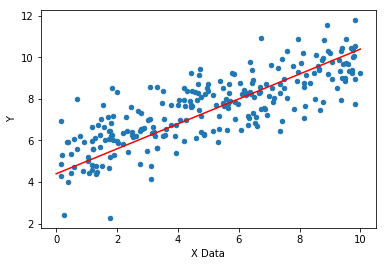

In [57]:
#again sampling from original data to not to plot 1M records
my_data.sample(n=250).plot(kind='scatter', x='X Data', y='Y')
plt.plot(brand_new_data, preds, 'r')